In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [66]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [67]:
# Flatten the images to be vectors
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

In [92]:
# Convert the digit labels to even/odd labels:
# Even -> 0, Odd -> 1
y_train = np.array([label % 2 for label in y_train])
y_test = np.array([label % 2 for label in y_test])

unique, counts = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test class distribution: {dict(zip(unique, counts))}")

Training class distribution: {0: 29492, 1: 30508}
Test class distribution: {0: 4926, 1: 5074}


In [141]:
# Initializing parameters
n_features = x_train.shape[1]
w1 = np.random.randn(n_features) * 0.1
G1 = np.random.randn(n_features) * 0.1
b = np.random.randn() * 0.1
learning_rate = 0.05

In [94]:
# sigmoid activation function that returns the probabilistic output D
def sigmoid(z):
  z = np.clip(z, -50, 50)
  return 1 / (1 + np.exp(-z))

In [161]:
def train_entropy_gradient(x_train, y_train, epochs=50, batch_size=32):
    global w1, G1, b
    num_samples = x_train.shape[0]
    accuracies = []

    # Learning rate dynamic adjustment
    initial_learning_rate = 0.01
    max_learning_rate = 0.05
    min_learning_rate = 0.001

    # Delta dynamic adjustment
    initial_delta = 0.2
    final_delta = 0.05

    prev_accuracy = 0  # Track last epoch's accuracy

    for epoch in range(epochs):
        indices = np.random.permutation(num_samples)
        x_train, y_train = x_train[indices], y_train[indices]

        # Adjust learning rate dynamically
        learning_rate = max(min_learning_rate, min(max_learning_rate, initial_learning_rate * (1.02 ** epoch)))
        if epoch > 1 and accuracies[-1] > prev_accuracy:
            learning_rate = min(max_learning_rate, learning_rate * 1.05)
        elif epoch > 1 and accuracies[-1] <= prev_accuracy:
            learning_rate = max(min_learning_rate, learning_rate * 0.9)

        prev_accuracy = accuracies[-1] if epoch > 1 else 0

        delta = max(final_delta, initial_delta * (0.98 ** epoch))

        for i in range(0, num_samples, batch_size):
            x_batch = x_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]

            # Compute predictions
            z_old = np.dot(x_batch, (w1 + G1)) + b
            D = sigmoid(z_old)

            # Compute binary cross-entropy gradient
            grad = (D - y_batch)  # Difference between predicted and actual labels

            # Compute weight updates using gradient
            w1_update = -learning_rate * np.dot(grad, x_batch) / batch_size
            G1_update = -learning_rate * np.dot(grad, x_batch) / batch_size
            b_update = -learning_rate * np.mean(grad)

            # Updating the new knowledge value
            z_new = z_old + np.dot(x_batch, (w1_update + G1_update)) + b_update

            # Checking if the new knowledge value is violated in the batch and computing the highest violation of the z constraint
            max_violation = np.max(z_new - z_old - delta)

            # Atleast one sample has an update that exceeds delta, so a global scale factor is applied to all the samples in the batch
            if max_violation > 0:
              scale_factor = delta / (max_violation + 1e-8)
            else:
              scale_factor = 1.0 # No violation, so update remains unchanged

            # Applying the scaled updates
            w1 += scale_factor * w1_update
            G1 += scale_factor * G1_update
            b += scale_factor * b_update

        # Evaluate accuracy after each epoch
        z_test = np.dot(x_test, (w1 + G1)) + b
        predictions = (sigmoid(z_test) >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_test)
        accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}, Accuracy: {accuracy:.4f}")

    # Plot accuracy over epochs
    plt.plot(range(1, epochs + 1), accuracies, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.grid()
    plt.show()

In [145]:
def visualize_results():
    random_indices = np.random.randint(0, x_test.shape[0], size = 10)

    plt.figure(figsize = (15, 6))

    for idx, i in enumerate(random_indices):
        image = x_test[i].reshape(28, 28)
        true_label = y_test[i]
        prediction = (sigmoid(np.dot(x_test[i], (w1 + G1)) + b) >= 0.5).astype(int)

        plt.subplot(2, 5, idx + 1)
        plt.imshow(image, cmap = 'gray')
        plt.title(f"True: {'Odd' if true_label else 'Even'}\nPred: {'Odd' if prediction else 'Even'}")
        plt.axis('off')

    plt.show()

Epoch 1, Accuracy: 0.5074
Epoch 2, Accuracy: 0.7703
Epoch 3, Accuracy: 0.8072
Epoch 4, Accuracy: 0.8072
Epoch 5, Accuracy: 0.8043
Epoch 6, Accuracy: 0.8061
Epoch 7, Accuracy: 0.8069
Epoch 8, Accuracy: 0.8041
Epoch 9, Accuracy: 0.8027
Epoch 10, Accuracy: 0.8051
Epoch 11, Accuracy: 0.8070
Epoch 12, Accuracy: 0.8076
Epoch 13, Accuracy: 0.8078
Epoch 14, Accuracy: 0.8047
Epoch 15, Accuracy: 0.8056
Epoch 16, Accuracy: 0.8058
Epoch 17, Accuracy: 0.8054
Epoch 18, Accuracy: 0.8062
Epoch 19, Accuracy: 0.8032
Epoch 20, Accuracy: 0.8040
Epoch 21, Accuracy: 0.8018
Epoch 22, Accuracy: 0.8087
Epoch 23, Accuracy: 0.8072
Epoch 24, Accuracy: 0.8058
Epoch 25, Accuracy: 0.8072
Epoch 26, Accuracy: 0.8048
Epoch 27, Accuracy: 0.8060
Epoch 28, Accuracy: 0.8018
Epoch 29, Accuracy: 0.8082
Epoch 30, Accuracy: 0.8065
Epoch 31, Accuracy: 0.8043
Epoch 32, Accuracy: 0.8069
Epoch 33, Accuracy: 0.8016
Epoch 34, Accuracy: 0.8076
Epoch 35, Accuracy: 0.8072
Epoch 36, Accuracy: 0.8080
Epoch 37, Accuracy: 0.8051
Epoch 38, 

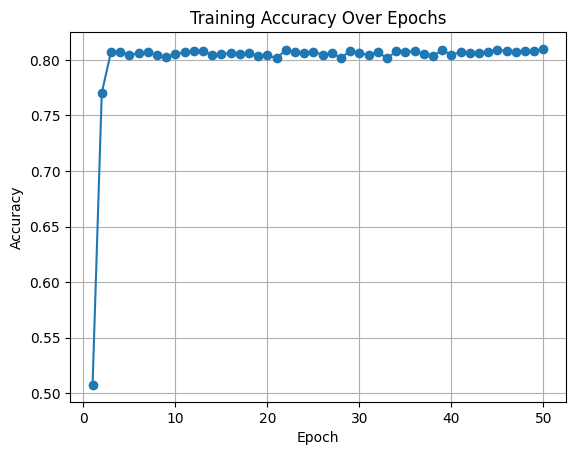

In [162]:
# Train and visualize results
train_entropy_gradient(x_train, y_train, epochs=50)

In [163]:
def evaluate_model():
    # Computing z for the test set
    z_test = np.dot(x_test, (w1 + G1)) + b

    # Applying sigmoid to convert into probabilities
    D_test = sigmoid(z_test)

    # Converting probabilities into binary predictions (0 for even, 1 for odd)
    predictions = (D_test >= 0.5).astype(int)

    # Computing accuracy: percentage of correct predictions
    accuracy = np.mean(predictions == y_test)

    print(f"\nFinal Test Accuracy: {accuracy:.4f}")

# Call this function after training
evaluate_model()


Final Test Accuracy: 0.8099


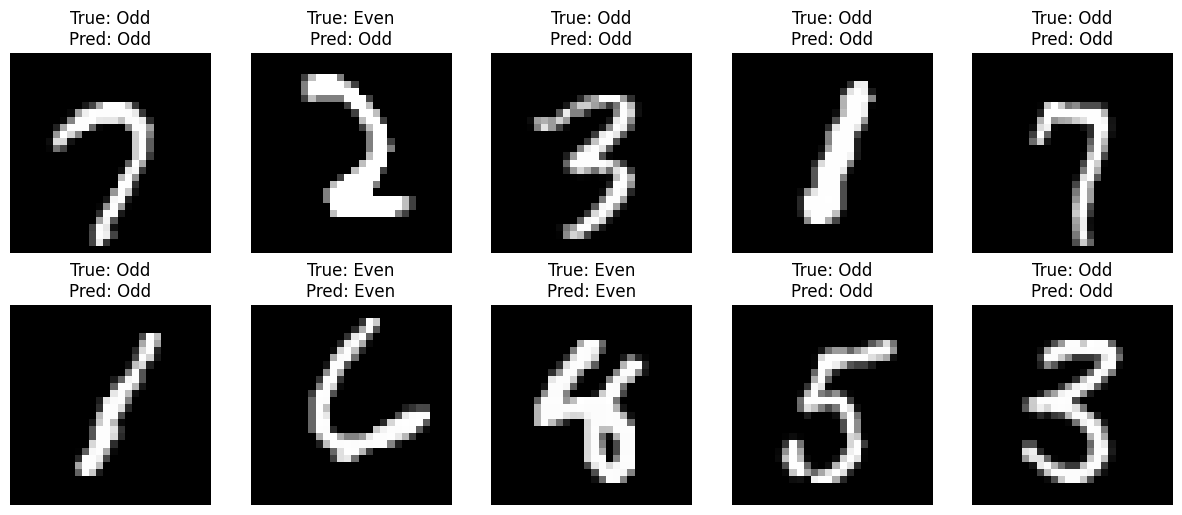

In [164]:
visualize_results()